# Neo4j Graph Data Science Workshop: In-Depth Graph Exploratory Data Analysis 
This notebook is part of an overall Neo4j Graph Data Science (GDS) [Patient Journey series of demonstration notebooks](https://github.com/danb-neo4j/patient_journey/blob/main/README.md). Existing notebooks currently address:
* [Tabular Exploratory Data Analysis (EDA)](https://github.com/danb-neo4j/patient_journey/blob/main/patientJourney_tabularEDA.ipynb), 
* [Graph Data Loading](https://github.com/danb-neo4j/patient_journey/blob/main/patientJourney_dataLoad.ipynb), and 
* [Patient Community Analysis](https://github.com/danb-neo4j/patient_journey/blob/main/patientJourney_nodeSimilarity.ipynb). 

This notebook fills an important gap in that series by demonstrating an in-depth approach to [Graph EDA](https://github.com/danb-neo4j/gds-guide/blob/main/graph-eda.md). 

# Import Libraries

In [87]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(12,7)})

import os
import subprocess
import sys
import importlib
import configparser
from IPython.display import Image

In [2]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Successfully imported GraphDataScience


In [3]:
# set local working directory
os.chdir('/Users/danielbukowski/Documents/GDS/patient_journey')

# Connect to Neo4j Database
We will use the [neoUtils](https://github.com/danb-neo4j/patient_journey/blob/main/neoUtils.py) module to read-in autentication credentials and connect the GDS library to our AuraDS instance.

In [4]:
# import utility function to connect to Neo4j DB
from neoUtils import read_neo4j_properties

In [5]:
# read in Neo4j host and authentication 
NEO4J_PROPERTIES_FILE = 'auth/patientJourney_auth.ini'
# NEO4J_PROPERTIES_FILE = 'patientJourney_auth.ini'
HOST, USERNAME, PASSWORD = read_neo4j_properties(NEO4J_PROPERTIES_FILE=NEO4J_PROPERTIES_FILE)

Using HOST, USERNAME, PASSWORD from .ini file


In [6]:
# instantiate GDS and connect to database 
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)

# confirm connection with gds version 
print('Neo4j GDS Version:', gds.version())

Neo4j GDS Version: 2.4.2+26


# Preliminary GraphEDA
The Synthea Patient Data used in this notebook is a larger version of the same data used in [Graph Data Processing with Cypher](https://github.com/PacktPublishing/Cypher-Querying). The data was [loaded into the database](https://github.com/danb-neo4j/patient_journey/blob/main/patientJourney_dataLoad.ipynb) using scripts from this text. 

## Graph Schema
The first thing we always want to do is view the graph schema as the database understands it. To do so we can use the `CALL db.schema.visualization()` Cypher procedure. However, you will need to do so via the Neo4j Browser or Bloom, as the output is an interactive visualization that we canno visualize via the GDS Python client.

## Initial Data Quality Issues

### Identify Unconnected Nodes
Unconnected nodes often indicate a data quality issue, outliers in the data, or an issue loading the data into the graph. It is generally recommend to explore the root cause of their occurrence before deciding how to handle them.

In [7]:
print('Count of nodes that do not have relationships:') 
gds.run_cypher('''
MATCH (n)
WHERE NOT (n)--()
RETURN COUNT(n) as nodeCount
''')

Count of nodes that do not have relationships:


,nodeCount
0,0


### Identify Unlabeled Nodes
Unlabeled nodes are also a potential issue to address early in the Graph EDA process. They also typically occur for two reasons:
* Data quality issue
* Data ingestion issue 

It is recommended to identify the root causes of a graph containing unlabeled nodes before determing how to address them. 

In [8]:
unlabeled_node_ct = gds.run_cypher("""
MATCH (n)
WHERE labels(n) = []
RETURN COUNT(n) AS count
""")

print('Count of unlabeled nodes:', unlabeled_node_ct['count'][0])

Count of unlabeled nodes: 586915


*Analysis:* Running the following Cypher code in the Neo4j Browser will return ten of the unlabeled nodes.
```
MATCH (n)
    WHERE labels(n) = []
RETURN n
LIMIT 10
```
Upon examination, these appear to be unlabeled `Drug` nodes with a single in-degree `HAS_DRUG` relationship from an `Encounter` node that has an end-date. 

Issues like this highlight the importance of GraphEDA and feature creation for detecting potential data quality or data load issues when the data is converted from tabular to graph.

### Delete Unlabeled Nodes
Based on the analysis above we will remove the unlabeled nodes and their relationships from the graph. There appears to be a minor issue in the ingestion script and deleting the unlabled nodes will not impact our overall analysis.

In [9]:
gds.run_cypher('''
MATCH (n) 
    WHERE labels(n) = []
CALL { WITH n 
DETACH DELETE n 
} IN TRANSACTIONS OF 50000 ROWS
''')

""


In [10]:
# update count of unlabeled nodes
unlabeled_node_ct = gds.run_cypher("""
MATCH (n)
WHERE labels(n) = []
RETURN COUNT(n) AS count
""")

print('UPDATED Count of unlabeled nodes:', unlabeled_node_ct['count'][0])

UPDATED Count of unlabeled nodes: 0


## Graph Overview
We will call `apoc.meta.stats()` to get a high-level overview of the graph. This will return a JSON object that will be converted automatically to a pandas DataFrame.

In [11]:
# call apoc.meta.stats() to get a summary of the graph
apoc_stats = gds.run_cypher("CALL apoc.meta.stats()")

In [12]:
# # view full dataframe 
apoc_stats

labelCount  relTypeCount  propertyKeyCount  nodeCount  relCount  \
0          26            18                26    1307205   5445753   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                labels  \
0  {'Allergy': 21, 'Organization': 1088, 'Wellness': 118041, 'Snf': 828, 'SNOMED_CT': 524, 'CarePlan': 22293, 'Race': 6, 'Encounter': 1274720, 'Procedure': 271, 'Outpatient': 74710, 'Ambulatory': 237163, 'Diagnosis': 137, 'Home': 1861, 'Drug': 326, 'Condition': 271, 'Urgentcare': 38239, 'ZipCode': 1272, 'Patient': 5885, 'Virtual': 450, 'Care': 40, 'Provider': 1088, 'Specialty': 1, 'Ethnicity': 2, 'Hospice': 996, 'Inpatient': 6480, 'Emergency': 18647}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [14]:
# view sleceted fields
apoc_stats[['nodeCount', 'labelCount', 'relCount', 'relTypeCount']]

,nodeCount,labelCount,relCount,relTypeCount
0,1307205,26,5445753,18


# Nodes

## Node Label Counts

In [13]:
# parse nodetype and count into dataframe 
nodeType_counts = pd.DataFrame(apoc_stats['labels'][0].items(), columns=['nodeType', 'count']).sort_values(by='count', ascending=False)
print('total node count:', nodeType_counts['count'].sum())

total node count: 1805360


In [17]:
# view full dataframe 
nodeType_counts

,nodeType,count
7,Encounter,1274720
10,Ambulatory,237163
2,Wellness,118041
9,Outpatient,74710
15,Urgentcare,38239
5,CarePlan,22293
25,Emergency,18647
24,Inpatient,6480
17,Patient,5885
12,Home,1861


**Be Careful Counting Node Labels:**

*Note: the 'labels' feature of `apoc.meta.stats()` includes each node label individually, even when there are multiple labels on the same node. As shown above, this will provide the count of each label, but if you sum all of the rows it will result in over counting the total nodes in the graph. Therefore, we will need to count nodes by type another way.*

## Single-Label Nodes
Because our database contains nodes with multiple labels, we will want to analyze both single-label and multi-label nodes separately. 

In [14]:
# query for single-label node labels with counts 
singleLabels = gds.run_cypher("""
                              MATCH (n) 
                              WITH n, labels(n) as node_labels
                              WHERE size(node_labels) = 1
                              WITH node_labels[0] as uniqueLabels
                              RETURN uniqueLabels, count(uniqueLabels) as count
                              ORDER BY count DESC
                              """)
print('Singluar, unique node labels with counts:')
singleLabels 

Singluar, unique node labels with counts:


,uniqueLabels,count
0,Encounter,777305
1,CarePlan,22293
2,Patient,5885
3,ZipCode,1272
4,Provider,1088
5,Organization,1088
6,Drug,326
7,SNOMED_CT,55
8,Race,6
9,Ethnicity,2


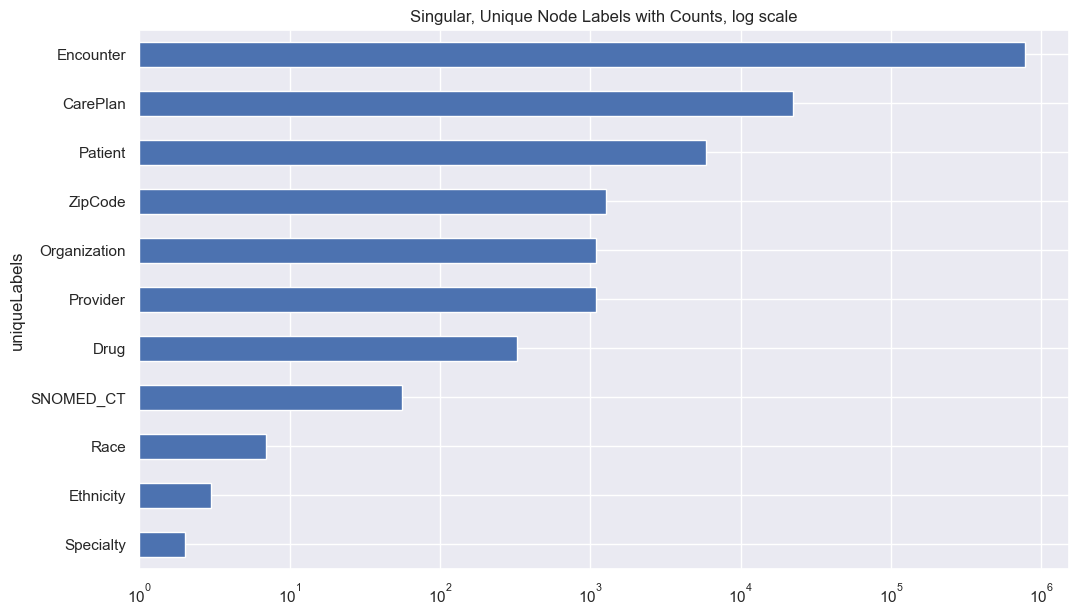

In [15]:
(
    singleLabels
    .set_index('uniqueLabels')
    .sort_values(by='count', ascending=True)
    .plot(kind='barh', title='Singular, Unique Node Labels with Counts, log scale', log=True, legend=None, figsize=(12,7))
)
plt.show()

## Multi-Label Nodes

In [16]:
labelCombinations = gds.run_cypher("""
                              MATCH (n) 
                              WITH n, labels(n) as node_labels
                              WHERE size(node_labels) > 1
                              WITH node_labels as labelCombinations
                              RETURN labelCombinations, count(labelCombinations) as nodeCount
                              ORDER BY nodeCount DESC
                              """)

In [17]:
# add label count to label combinations
labelCombinations['labelCount'] = labelCombinations['labelCombinations'].apply(lambda x: len(x))

# reorder dataframe columns
labelCombinations = labelCombinations[['labelCombinations', 'labelCount', 'nodeCount']]

print('Multi-label combinations with counts:')
labelCombinations.sort_values(by='labelCount', ascending=False) 
 

Multi-label combinations with counts:


,labelCombinations,labelCount,nodeCount
10,"[SNOMED_CT, Condition, Procedure]",3,271
0,"[Encounter, Ambulatory]",2,237163
1,"[Encounter, Wellness]",2,118041
2,"[Encounter, Outpatient]",2,74710
3,"[Encounter, Urgentcare]",2,38239
4,"[Encounter, Emergency]",2,18647
5,"[Encounter, Inpatient]",2,6480
6,"[Encounter, Home]",2,1861
7,"[Encounter, Hospice]",2,996
8,"[Encounter, Snf]",2,828


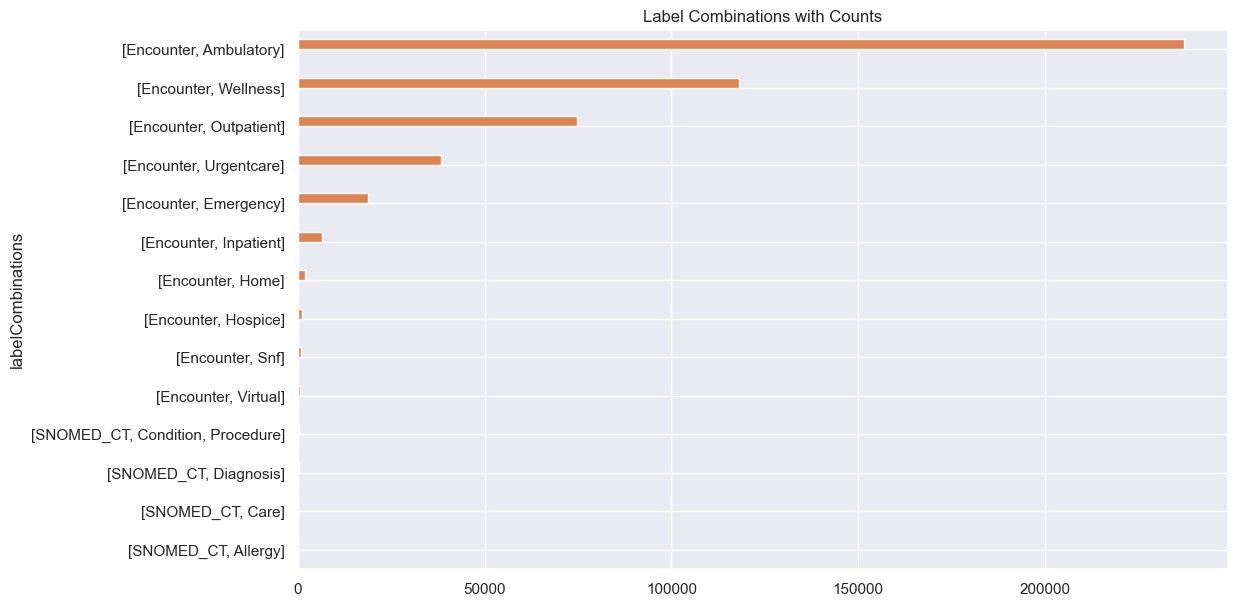

In [18]:
(
    labelCombinations
    .set_index('labelCombinations')
    .sort_values(by='nodeCount', ascending=True)
    .plot(kind='barh', title='Label Combinations with Counts', log=False, legend=None, figsize=(12,7))
)
plt.show()

## Node Properties 
We will use `db.schema.nodeTypeProperties()` along with two functions below to retrieve and organize Node Property data.

In [19]:
# function to preprocess dataframe
def reorder_labels(labels_list) -> list:
    """Reorder node labels returned from db.schema.nodeTypeProperties()
    Inputs:
        labels_list: list of strings, the node labels to reorder
    Returns:
        labels_list: list of strings, the reordered node labels
    """
    if 'SNOMED_CT' in labels_list:
        labels_list.remove('SNOMED_CT')
        labels_list.insert(0, 'SNOMED_CT')
    if 'Encounter' in labels_list:
        labels_list.remove('Encounter')
        labels_list.insert(0, 'Encounter')
    return labels_list

In [20]:
def gen_nodeLabel_properties() -> pd.DataFrame:
  '''calls db.schema.nodeTypeProperties() to return node properties
     combines these with node multi-labels and returns as a table
     
  args:
    None

  returns:
    processed node label dataframe 
  '''
  # query for nodeProperty schema dataframe 
  raw_labels_df = gds.run_cypher('''CALL db.schema.nodeTypeProperties()''')

  # preprocess nodeLabels column
  raw_labels_df['nodeLabels'] = raw_labels_df['nodeLabels'].apply(reorder_labels)

  # split labels column into multiple columns
  node_labels = raw_labels_df['nodeLabels'].apply(pd.Series)

  # rename columns
  node_labels.rename(columns = lambda x : 'label_' + str(x), inplace=True)

  # concatenate back to original dataframe
  node_properties_df = pd.concat([raw_labels_df, node_labels], axis=1)

  # slice and reorder columns 
  node_properties_df = node_properties_df[['label_0', 'label_1', 'label_2', 'propertyName', 'propertyTypes', 'mandatory']] 

  # sort values 
  node_properties_df.sort_values(by=['label_0', 'label_1', 'label_2', 'propertyName'], ascending=[True, True, True, True], inplace=True)

  # view dimensions 
  return node_properties_df

In [21]:
node_properties_df = gen_nodeLabel_properties()
node_properties_df.shape

(96, 6)

In [27]:
# view first 15 rows of the dataframe
node_properties_df.head(15)

,label_0,label_1,label_2,propertyName,propertyTypes,mandatory
95,CarePlan,NaN,NaN,code,[String],True
89,Drug,NaN,NaN,code,[Long],True
90,Drug,NaN,NaN,description,[String],True
18,Encounter,Ambulatory,NaN,date,[DateTime],True
19,Encounter,Ambulatory,NaN,description,[String],True
21,Encounter,Ambulatory,NaN,end,[DateTime],True
17,Encounter,Ambulatory,NaN,id,[String],True
20,Encounter,Ambulatory,NaN,isEnd,[Boolean],True
8,Encounter,Emergency,NaN,date,[DateTime],True
9,Encounter,Emergency,NaN,description,[String],True


In [27]:
print('count of unique node properties:', node_properties_df['propertyName'].nunique())

count of unique node properties: 26


In [28]:
node_properties_df['mandatory'].value_counts()

True     92
False     4
Name: mandatory, dtype: int64

In [29]:
node_properties_df[node_properties_df['mandatory'] == False] 

,label_0,label_1,label_2,propertyName,propertyTypes,mandatory
71,Encounter,NaN,NaN,code,[Long],False
64,Patient,NaN,NaN,age,[Double],False
65,Patient,NaN,NaN,expenses,[Double],False
66,Patient,NaN,NaN,income,[Long],False


# Relationships

## Relationship Type Counts
For relationships we can parse the results from the output of our prior `apoc.meta.stats()` call. There are no multi-label relationships, so we do not need to handle them differently like we did with the nodes.

In [30]:
relationshipType_counts = pd.DataFrame(apoc_stats['relTypesCount'][0].items(), columns=['relType', 'count']).sort_values(by='count', ascending=False)
relationshipType_counts = relationshipType_counts.set_index(['relType'])

print('Total count of relationships with labels:', relationshipType_counts['count'].sum())

Total count of relationships with labels: 5445753


In [31]:
relationshipType_counts

,count
relType,
HAS_ENCOUNTER,1274720
HAS_END,777305
HAS_DRUG,569538
HAS_DIAGNOSIS,517612
OF_TYPE,497415
HAS_ORGANIZATION,497415
HAS_PROVIDER,497415
HAS_CONDITION,455938
HAS_PROCEDURE,254432


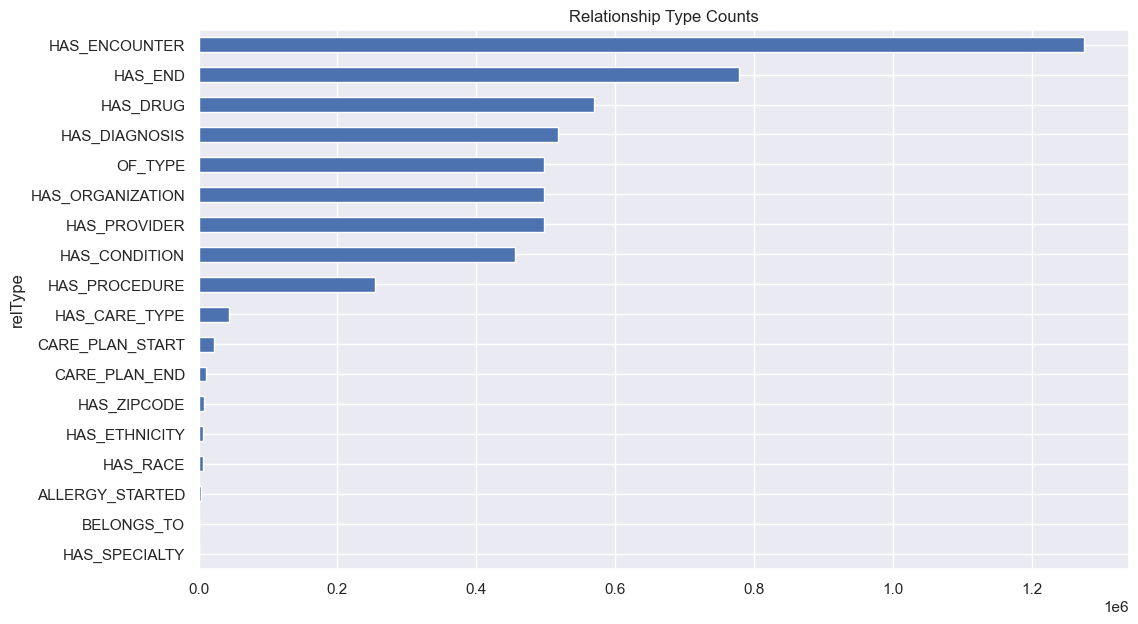

In [32]:
# plot node label counts with bars
relationshipType_counts.sort_values(by='count', ascending=True).plot(kind='barh', figsize=(12,7), title='Relationship Type Counts', legend=False)
plt.show()

As with the Node analysis, we could also obtain this information from the following Cypher:
```
CALL apoc.meta.stats()
YIELD relTypesCount
UNWIND keys(relTypesCount) AS relationshipType
RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
ORDER BY relationshipCount DESC
```

## Relationship Properties 
We will use `db.schema.relTypeProperties()` to generate the relationship properties data.

In [32]:
def gen_relType_properties() -> None:
  '''generate and print table of relationship properties
  inputs:
    None

  outputs:
    None; prints table to notebook
  '''
  # query for schema dataframe 
  rel_properties_df = gds.run_cypher('''CALL db.schema.relTypeProperties()''')

  # remove extra text from nodeType column
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace('`', '')
  rel_properties_df['relType'] = rel_properties_df['relType'].str.replace(':', '')

  # view dimensions 
  print(rel_properties_df.sort_values(by='relType', ascending=True).set_index(['relType']))

In [33]:
gen_relType_properties()

                 propertyName propertyTypes  mandatory
relType                                               
ALLERGY_STARTED          None          None      False
BELONGS_TO               None          None      False
CARE_PLAN_END            None          None      False
CARE_PLAN_START          None          None      False
HAS_CARE_TYPE            None          None      False
HAS_CONDITION            None          None      False
HAS_DIAGNOSIS            None          None      False
HAS_DRUG                 None          None      False
HAS_ENCOUNTER            None          None      False
HAS_END                  None          None      False
HAS_ETHNICITY            None          None      False
HAS_ORGANIZATION         None          None      False
HAS_PROCEDURE            None          None      False
HAS_PROVIDER             None          None      False
HAS_RACE                 None          None      False
HAS_SPECIALTY            None          None      False
HAS_ZIPCOD

# Node Degree Analysis
We will use the [Degree Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/degree-centrality/) algorithm to identify the most connected nodes in the graph. This will count outgoing nodes from each graph and help us identify the distribution of connections for each type of node in our graph. 

## Create Graph Projection
For this part of the analysis we will create a projection containing all nodes and all relationships in the graph. This may not always be feasible based upon the size of the graph or the memory available on the machine, for for this graph it is a reasonable approach.

In [34]:
# create graph projection with all nodes and all relationships
g, _ = gds.graph.project(graph_name='patient_journey_graph', 
                         node_spec='*',
                         relationship_spec='*')


Loading:   0%|          | 0/100 [00:00<?, ?%/s]

## Inspect the Graph Object
The Neo4j GDS Graph Object (created by projections) has several built-in methods that we can use to understand the contents of the projection.

In [36]:
print('Graph projection node count:', g.node_count())
print('Graph projection node labels', g.node_labels())
print('Graph projection relationship count:', g.relationship_count())
print('Graph projection relationship types:', g.relationship_types())


Graph projection node count: 1307205
Graph projection node labels ['__ALL__']
Graph projection relationship count: 5445753
Graph projection relationship types: ['__ALL__']


### Graph Density
The `.density()` method returns the graph density. This is calculated as the actual number of edges in the graph divided by the possible maximum number of edges in the graph. It is a measure of how connected the nodes are to each other, across the entire graph, or put another way how dense or sparse the graph is. 

In [40]:
# graph density 
density = g.density()
round(density, 10)

3.1869e-06

### Out-Degree Summary Statistics
The graph object also has the `.degree_distribution()` method which returns a summary of the node out-degrees. The out degree is also the default for the GDS Degree Centrality Algorithm. We will run it here in the interim before leveraging the GDS algorithm.

In [35]:
index_order = ['min', 'mean', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']
df = pd.DataFrame(g.degree_distribution(), columns=['degree'])

print('Degree Distribution of Full Graph')
df.loc[index_order].round(3)

Degree Distribution of Full Graph


,degree
min,0.000
mean,4.166
p50,1.000
p75,6.000
p90,11.000
p95,15.000
p99,23.000
max,9446.000


## Create Degree Centrality Node Properties
Here we will run the GDS Degree Centrality algorithm to create new in-degree and out-degree properties for each node in the graph. These node degree properties will help us further analyze the graph, understand its structure, and identify potential issues. 

### Node Out-Degree

In [36]:
_ = gds.degree.write(G=g, 
                     orientation='NATURAL',
                     writeProperty='degree_out') 

In [37]:
# confirm the proper number of properties are written 
assert pd.DataFrame(_)[0]['nodePropertiesWritten'] == g.node_count()

### Node In-Degree

In [38]:
_ = gds.degree.write(G=g, 
                     orientation='REVERSE',
                     writeProperty='degree_in') 

In [39]:
# confirm the proper number of properties are written 
assert pd.DataFrame(_)[0]['nodePropertiesWritten'] == g.node_count()

## Analyze Node Degrees

## Create Node/Label Degree DataFrame 

First we will create a dataframe of the node id, labels, and degree statistics. This will allow us to easily filter and sort the nodes based on the degree statistics and better understand important nodes within our graph.

In [40]:
node_degree_centrality = gds.run_cypher("""
MATCH (n)
RETURN
    id(n) AS id,
    labels(n) AS labels,
    n.degree_out AS degree_out,
    n.degree_in AS degree_in
ORDER BY labels ASC, degree_out DESC
""")
                                        
node_degree_centrality.shape

(1307205, 4)

In [41]:
# lengths = node_degree_centrality['labels'].apply(lambda x: len(x))
# node_degree_centrality['label_count'] = lengths 

node_degree_centrality['label_count'] = node_degree_centrality['labels'].apply(lambda x: len(x))

In [42]:
# split labels column into multiple columns
labels_df = node_degree_centrality['labels'].apply(pd.Series)

# rename columns
labels_df = labels_df.rename(columns = lambda x : 'label_' + str(x))

# concatenate back to original dataframe
node_degree_centrality = pd.concat([node_degree_centrality, labels_df], axis=1)

## Analyze Node Degrees

### Overall Node Degree Distributions

In [43]:
totalNode_degree_distrib = node_degree_centrality[['degree_out', 'degree_in']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()  
totalNode_degree_distrib

,degree_out,degree_in
count,1307205.0,1307205.0
mean,4.0,4.0
std,35.0,394.0
min,0.0,0.0
25%,0.0,1.0
50%,1.0,2.0
75%,6.0,2.0
90%,11.0,2.0
95%,15.0,2.0
99%,23.0,2.0


### Overall Nodes with Highest Out-Degree

In [44]:
node_degree_centrality.sort_values(by='degree_out', ascending=False).head(10)   

,id,labels,degree_out,degree_in,label_count,label_0,label_1,label_2
1298429,6126,[Patient],9446.0,0.0,1,Patient,NaN,NaN
1298430,5197,[Patient],8439.0,0.0,1,Patient,NaN,NaN
1298431,5090,[Patient],7040.0,0.0,1,Patient,NaN,NaN
1298432,3892,[Patient],6451.0,0.0,1,Patient,NaN,NaN
1298433,1511,[Patient],6126.0,0.0,1,Patient,NaN,NaN
1298434,4016,[Patient],5809.0,0.0,1,Patient,NaN,NaN
1298435,2573,[Patient],4788.0,0.0,1,Patient,NaN,NaN
1298436,1772,[Patient],4723.0,0.0,1,Patient,NaN,NaN
1298437,2065,[Patient],4382.0,0.0,1,Patient,NaN,NaN
1298438,3467,[Patient],4197.0,0.0,1,Patient,NaN,NaN


### Overall Nodes with Highest In-Degree

In [45]:
node_degree_centrality.sort_values(by='degree_in', ascending=False).head(10)   

,id,labels,degree_out,degree_in,label_count,label_0,label_1,label_2
1305552,1681107,"[SNOMED_CT, Condition, Procedure]",0.0,274366.0,3,SNOMED_CT,Condition,Procedure
1305419,6239,[SNOMED_CT],0.0,160810.0,1,SNOMED_CT,NaN,NaN
22493,507921,[Drug],0.0,102295.0,1,Drug,NaN,NaN
1305810,507922,"[SNOMED_CT, Diagnosis]",0.0,102295.0,2,SNOMED_CT,Diagnosis,NaN
1305555,1681114,"[SNOMED_CT, Condition, Procedure]",0.0,99601.0,3,SNOMED_CT,Condition,Procedure
1305415,6214,[SNOMED_CT],0.0,96837.0,1,SNOMED_CT,NaN,NaN
22399,506848,[Drug],0.0,88255.0,1,Drug,NaN,NaN
1305903,506849,"[SNOMED_CT, Diagnosis]",0.0,88236.0,2,SNOMED_CT,Diagnosis,NaN
22443,506928,[Drug],0.0,75114.0,1,Drug,NaN,NaN
1305795,506929,"[SNOMED_CT, Diagnosis]",0.0,75114.0,2,SNOMED_CT,Diagnosis,NaN


# Node-Relationship-Node Patterns
As part of exploring nodes and relationships, we will identify node-relationship-node patterns in our graph to understand what types of relationships exist and how they connect various nodes. 

## Query for Relationship Pattern by Count in the Data

In [46]:
node_rel_patterns = gds.run_cypher("""
MATCH (n)-[r]->(m)
WHERE SIZE(labels(n)) > 0 AND SIZE(labels(m)) > 0
RETURN
    labels(n) as source_labels, 
    type(r) as relationships, 
    labels(m) as target_labels, 
    count(*) AS count
ORDER BY source_labels DESC, relationships ASC, target_labels ASC
""")
node_rel_patterns.shape

(117, 4)

In [49]:
# view first 25 results
node_rel_patterns.head(25)

,source_labels,relationships,target_labels,count
0,[Provider],BELONGS_TO,[Organization],1088
1,[Provider],HAS_SPECIALTY,[Specialty],1088
2,[Provider],HAS_ZIPCODE,[ZipCode],1088
3,[Patient],HAS_ENCOUNTER,[Encounter],777305
4,[Patient],HAS_ENCOUNTER,"[Encounter, Ambulatory]",237163
5,[Patient],HAS_ENCOUNTER,"[Encounter, Emergency]",18647
6,[Patient],HAS_ENCOUNTER,"[Encounter, Home]",1861
7,[Patient],HAS_ENCOUNTER,"[Encounter, Hospice]",996
8,[Patient],HAS_ENCOUNTER,"[Encounter, Inpatient]",6480
9,[Patient],HAS_ENCOUNTER,"[Encounter, Outpatient]",74710


# Patient Node Analysis
The focus of our patient journey analysis is on the patient experience, so we will start our GraphEDA with Patient nodes. 

## Patient Node In-Degree and Out-Degree

In [51]:
print('Patient Node In-Degree and Out-Degree:')
patient_nodeDegree = node_degree_centrality[node_degree_centrality['label_0'] == 'Patient'][['degree_out', 'degree_in']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()  
patient_nodeDegree

Patient Node In-Degree and Out-Degree:


,degree_out,degree_in
count,5885.0,5885.0
mean,220.0,0.0
std,463.0,0.0
min,4.0,0.0
25%,42.0,0.0
50%,86.0,0.0
75%,164.0,0.0
90%,472.0,0.0
95%,1119.0,0.0
99%,2002.0,0.0


## Patient Node Properties
View the properties of the Patient nodes.

In [52]:
node_properties_df[node_properties_df['label_0'] == 'Patient']

,label_0,label_1,label_2,propertyName,propertyTypes,mandatory
64,Patient,NaN,NaN,age,[Double],False
63,Patient,NaN,NaN,birthDate,[Date],True
59,Patient,NaN,NaN,city,[String],True
60,Patient,NaN,NaN,county,[String],True
62,Patient,NaN,NaN,drivers,"[String, Double]",True
65,Patient,NaN,NaN,expenses,[Double],False
55,Patient,NaN,NaN,firstName,[String],True
52,Patient,NaN,NaN,id,[String],True
66,Patient,NaN,NaN,income,[Long],False
56,Patient,NaN,NaN,lastName,[String],True


In [53]:
# create a list variable to use later
patient_nodeProperties = node_properties_df[node_properties_df['label_0'] == 'Patient']['propertyName'].tolist()

### Identify Patients with Missing Properties

In [54]:
# identify if patients are missing any non-mandatory properties
patients_missing = gds.run_cypher("""
MATCH (p:Patient)
WHERE 
    (p.age) IS NULL OR 
    (p.expenses) IS NULL OR
    (p.income) IS NULL 
RETURN
    p.id AS patient_id,
    p.age AS patient_age,
    p.expenses AS patient_expenses,
    p.income AS patient_income
ORDER BY patient_id ASC
""")

patients_missing.shape

(31, 4)

In [55]:
patients_missing

,patient_id,patient_age,patient_expenses,patient_income
0,08c755d8-01a2-6174-0092-58bb88a5b640,None,None,None
1,0f81fbf4-9ffb-554c-0a30-7eaf81d818e5,None,None,None
2,1ac44f84-e7a6-b512-080c-24ec0bbbf12a,None,None,None
3,2952a4db-2b69-2c17-24ce-bb033eb25bf5,None,None,None
4,300b449e-facb-d423-78de-bb0a94373f0b,None,None,None
5,30947b63-b318-302d-9ff0-b2648ee7e13e,None,None,None
6,3c51881a-43a9-31cd-1b84-8ed1bf8a96d5,None,None,None
7,4086e3c9-d815-fc65-c3cc-df6bdfec38de,None,None,None
8,5822fba1-4c70-337e-5e39-514c9bcdbd3b,None,None,None
9,58b8b764-d28c-c319-5885-0ad93419b370,None,None,None


In [56]:
# delete patient nodes that are missing data
gds.run_cypher('''
MATCH (p:Patient)
WHERE 
    (p.age) IS NULL OR 
    (p.expenses) IS NULL OR
    (p.income) IS NULL 
CALL { WITH p 
DETACH DELETE p 
} IN TRANSACTIONS OF 50000 ROWS
''')

""


In [57]:
gds.run_cypher("""
MATCH (p:Patient)
WHERE 
    (p.age) IS NULL OR 
    (p.expenses) IS NULL OR
    (p.income) IS NULL 
RETURN count(p) AS count
""")

,count
0,0


## Patient Relationship Patterns

In [58]:
patient_relPatterns = node_rel_patterns[3:17] 
patient_relPatterns

,source_labels,relationships,target_labels,count
3,[Patient],HAS_ENCOUNTER,[Encounter],777305
4,[Patient],HAS_ENCOUNTER,"[Encounter, Ambulatory]",237163
5,[Patient],HAS_ENCOUNTER,"[Encounter, Emergency]",18647
6,[Patient],HAS_ENCOUNTER,"[Encounter, Home]",1861
7,[Patient],HAS_ENCOUNTER,"[Encounter, Hospice]",996
8,[Patient],HAS_ENCOUNTER,"[Encounter, Inpatient]",6480
9,[Patient],HAS_ENCOUNTER,"[Encounter, Outpatient]",74710
10,[Patient],HAS_ENCOUNTER,"[Encounter, Snf]",828
11,[Patient],HAS_ENCOUNTER,"[Encounter, Urgentcare]",38239
12,[Patient],HAS_ENCOUNTER,"[Encounter, Virtual]",450


## Create Encounter Features
We will create three new encounter features for each patient:
* `encounter_count`: the total number of encounters for each patient
* `emergency_encounter_count`: the total number of emergency encounters for each patient
* `urgentCare_encounter_count`: the total number of urgent care encounters for each patient

In [59]:
# query total encounter count for each patient
gds.run_cypher(""" 
MATCH (n:Patient)-[r:HAS_ENCOUNTER]->(e:Encounter)
WITH n, COUNT(r) AS encounter_count
SET n.encounter_count = encounter_count
""")

""


In [60]:
# query emergency encounter count for each patient
gds.run_cypher(""" 
MATCH (n:Patient)-[r:HAS_ENCOUNTER]->(e:Emergency)
WITH n, COUNT(r) AS emergency_count
SET n.emergency_count = emergency_count
""")

""


In [61]:
# fill missing values with 0
gds.run_cypher(""" 
MATCH (n:Patient)
WHERE n.emergency_count IS NULL
SET n.emergency_count = 0
""")

""


In [62]:
# query Urgentcare encounter count for each patient
gds.run_cypher(""" 
MATCH (n:Patient)-[r:HAS_ENCOUNTER]->(e:Urgentcare)
WITH n, COUNT(r) AS urgentCare_count
SET n.urgentCare_count = urgentCare_count
""")

""


In [63]:
# fill missing values with 0
gds.run_cypher(""" 
MATCH (n:Patient)
WHERE n.urgentCare_count IS NULL
SET n.urgentCare_count = 0
""")

""


## Examine New Features

In [64]:
# export patient age and encounter count to dataframe 
patient_newStats = gds.run_cypher("""
MATCH (n:Patient)
RETURN
    n.age AS age,
    n.expenses AS expenses,
    n.encounter_count AS encounter_count,
    n.emergency_count AS emergency_count,
    n.urgentCare_count AS urgentCare_count
""")
patient_newStats.shape

(5854, 5)

In [66]:
patient_newStats.head()

,age,expenses,encounter_count,emergency_count,urgentCare_count
0,31.0,36108.19,51,2,0
1,35.0,6685.55,39,2,0
2,43.0,37041.63,40,0,2
3,52.0,16736.57,66,5,0
4,55.0,57242.58,160,1,1


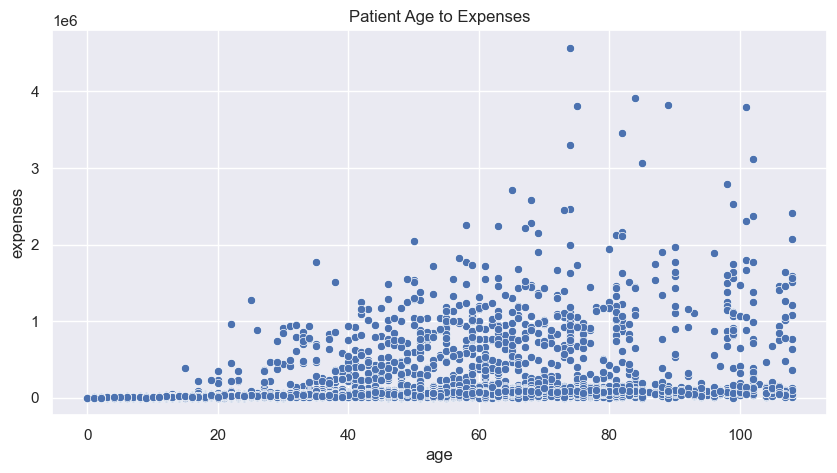

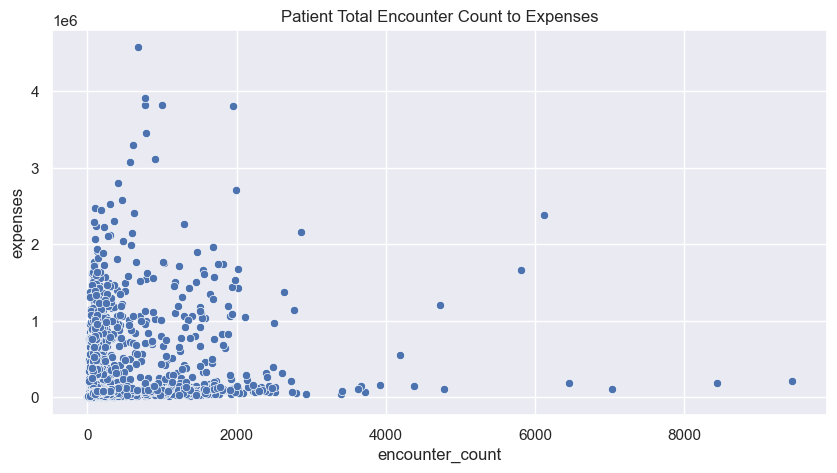

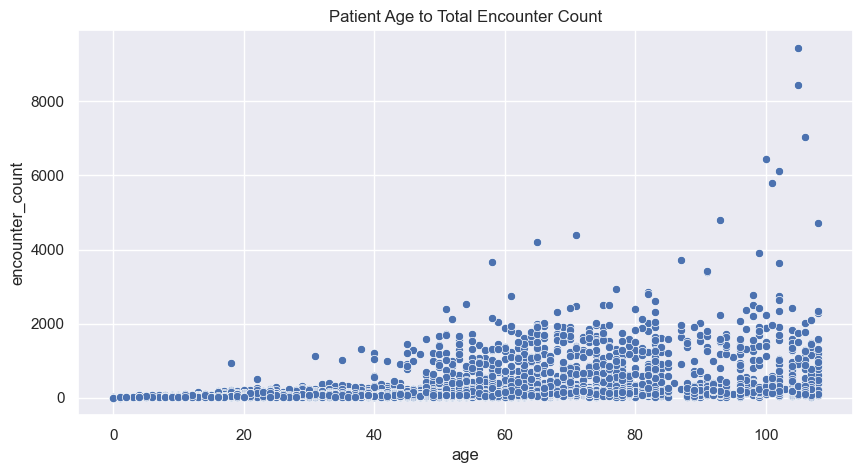

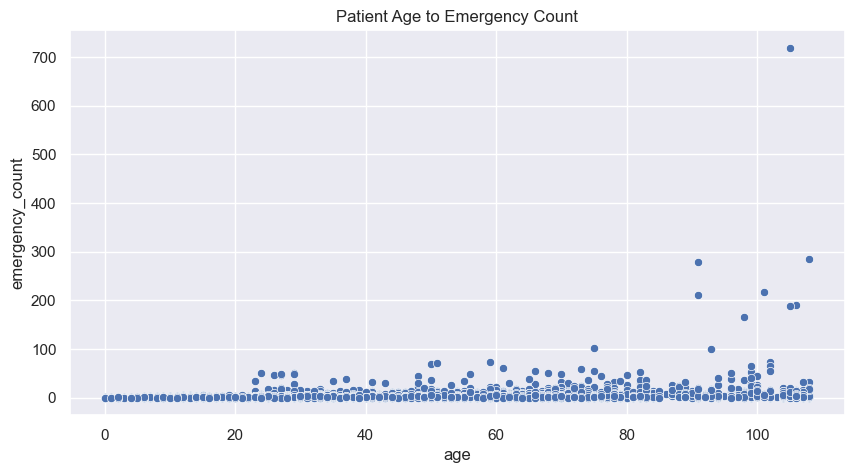

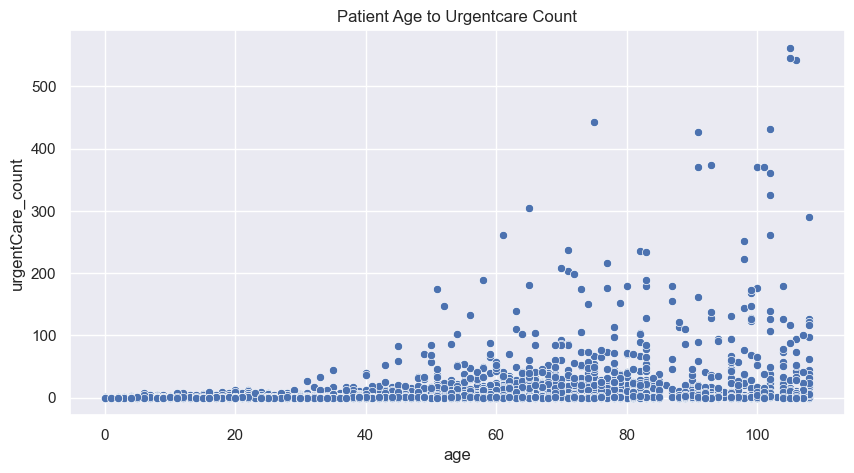

In [75]:
# create a separate scatterplot for each patient age to encounter count, emergency count, and urgentcare count
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='age', y='expenses', data=patient_newStats, ax=ax)
plt.title('Patient Age to Expenses')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='encounter_count', y='expenses', data=patient_newStats, ax=ax)
plt.title('Patient Total Encounter Count to Expenses')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='age', y='encounter_count', data=patient_newStats, ax=ax)
plt.title('Patient Age to Total Encounter Count')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='age', y='emergency_count', data=patient_newStats, ax=ax)
plt.title('Patient Age to Emergency Count')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='age', y='urgentCare_count', data=patient_newStats, ax=ax)
plt.title('Patient Age to Urgentcare Count')
plt.show()

# Patient Node Similarity Using KNN and Communities 

## Create Dummy Relationship Type
We will create a non-existent relationship type to use as a placeholder for the KNN algorithm. This will allow us to use the KNN algorithm to calculate the similarity between patients based on their encounter features without unnecessarily projecting relationships into memory.

In [67]:
# create empty relationship type
gds.run_cypher("""
CALL db.createRelationshipType('EMPTY')
""")

""


## Project Patient Nodes 

In [68]:
# drop any previous graph object 
# _ = g.drop()

In [69]:
# project Patient nodes, the placeholder relationship, and numeric properties for our analysis
g, _ = gds.graph.project(
    graph_name = 'patients', 
    node_spec = ['Patient'], 
    nodeProperties = ['age',
                      'expenses',
                      'income',
                      'encounter_count',
                      'emergency_count',
                      'urgentCare_count',
                      'degree_in',
                      'degree_out'],
    relationship_spec = 'EMPTY'
)

## Scale Properties 
KNN is sensitive to the scale of the properties, so we will scale the encounter features before running the algorithm.

In [71]:
_ = gds.alpha.scaleProperties.mutate(G = g, 
                                     nodeProperties = ['age',
                                                        'expenses',
                                                        'income',
                                                        'encounter_count',
                                                        'emergency_count',
                                                        'urgentCare_count',
                                                        'degree_in',
                                                        'degree_out'],
                                    scaler = 'Mean',
                                    mutateProperty = 'scaledProperties')

In [72]:
# confirm properties written back to patient nodes
pd.DataFrame(_)[0]['nodePropertiesWritten']

5854

## Apply KNN
First we will run KNN in Stats mode to identify the distribution, then we will run it on the projection to calculate the similarity between patients.

In [73]:
_ = gds.knn.stats(G = g,
                  topK=100,
                  nodeProperties=['scaledProperties'],
                  concurrency=6
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

In [74]:
pd.DataFrame(_)[0]['similarityDistribution']

{'p1': 0.9103126525878906,
 'max': 0.9999961853027344,
 'p5': 0.96044921875,
 'p90': 0.9998588562011719,
 'p50': 0.9978828430175781,
 'p95': 0.9999237060546875,
 'p10': 0.9770050048828125,
 'p75': 0.9995193481445312,
 'p99': 0.9999809265136719,
 'p25': 0.9914932250976562,
 'p100': 0.9999961853027344,
 'min': 0.6733207702636719,
 'mean': 0.9913655213687377,
 'stdDev': 0.01799736912314937}

In [75]:
_ = gds.knn.mutate(G = g,
                  topK=100,
                  nodeProperties=['scaledProperties'],
                  concurrency=6,
                  mutateRelationshipType="KNN_SIMILARITY",
                  mutateProperty="similarityScore"
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

## Identify Patient Communities
Once we have the homogenous similarity graph, we can run a community detection algorithm to identify communities of patients with similar demographis and encounter patterns.

### Label Propagation
Label Propagation (LPA) is a good first choice for fully connected graphs, like our similarity graph. We will write the LPA community back to the database so we can use it for further analysis.

In [76]:
# apply LPA and write back to the graph
_ = gds.labelPropagation.write(G = g, 
                               relationshipTypes = ['KNN_SIMILARITY'],
                               relationshipWeightProperty = 'similarityScore',
                               writeProperty = 'lpaCommunity')

In [78]:
# view the community distribution
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                                     21
communityDistribution    {'p99': 618, 'min': 74, 'max': 618, 'mean': 278.76190476190476, 'p90': 454, 'p50': 265, 'p999': 618, 'p95': 529, 'p75': 344}
Name: 0, dtype: object

## Calculate Weighted PageRank
Calculating PageRank, weighted by the similarity score, can provide another useful statistic for analyzing the patient communities. When analyzing a community, the patient with the highest PageRank score can serve as a de-facto representative of the community.

In [79]:
# calculate PageRank and write back to the graph 
_ = gds.pageRank.write(G=g, 
                       relationshipTypes=['KNN_SIMILARITY'], 
                       relationshipWeightProperty = 'similarityScore',
                       writeProperty='PageRank')

In [80]:
# view the score distribution 
pd.DataFrame(_)[0]['centralityDistribution']

{'p99': 2.282576560974121,
 'min': 0.14999961853027344,
 'max': 2.7570180892944336,
 'mean': 0.9612404364223239,
 'p90': 1.6293706893920898,
 'p50': 0.9583578109741211,
 'p999': 2.647871971130371,
 'p95': 1.8025808334350586,
 'p75': 1.3457632064819336}

## Analyze Patient Communities 
Finally, we will analyze the patient communities to understand the demographics and encounter patterns of each community. We will extract features from the graph into a DataFrame, then analyze the medians for each community to better understand the patients that were included in each. 

### Extract Patient Community DataFrame

In [81]:
patient_knn_df = gds.run_cypher('''
MATCH (p:Patient)
RETURN
    p.age AS age,
    p.expenses AS expenses,
    p.income AS income,
    p.encounter_count AS encounter_count,
    p.emergency_count AS emergency_count,
    p.urgentCare_count AS urgentCare_count,
    p.degree_in AS degree_in,
    p.degree_out AS degree_out,
    p.PageRank AS PageRank,
    p.lpaCommunity AS lpaCommunity
''')

patient_knn_df.shape

(5854, 10)

### Calculate Median and Group DataFrame

In [82]:
median_knn_df = patient_knn_df.groupby('lpaCommunity').median()
median_knn_df.shape

(21, 9)

In [83]:
knn_patient_counts = patient_knn_df[['age', 'lpaCommunity']].groupby('lpaCommunity').count()
knn_patient_counts.columns = ['patientCount']
knn_patient_counts.shape

(21, 1)

In [84]:
median_knn_df = median_knn_df.merge(knn_patient_counts, left_index=True, right_index=True)
median_knn_df.shape

(21, 10)

### View by Median Patients per Community

In [86]:
median_knn_df.sort_values(by='patientCount', ascending=False).round(2)

,age,expenses,income,encounter_count,emergency_count,urgentCare_count,degree_in,degree_out,PageRank,patientCount
lpaCommunity,,,,,,,,,,
3986,71.0,67814.50,76919.5,138.0,1.0,1.0,0.0,141.0,1.10,618
4499,61.0,859707.82,32867.0,140.0,2.0,1.0,0.0,143.0,0.69,529
3145,52.5,46789.54,38906.5,93.0,1.0,0.0,0.0,96.0,0.95,454
5077,68.0,64938.11,143773.5,133.0,2.0,1.0,0.0,136.0,0.73,408
1010,56.0,62366.61,564006.0,116.0,1.0,1.0,0.0,119.0,0.98,357
1324,71.5,96981.92,80496.0,1325.5,8.5,34.0,0.0,1328.5,0.61,344
1219,28.0,32926.02,28627.5,59.0,1.5,0.0,0.0,62.0,1.26,340
2469,23.0,28009.66,44923.5,42.0,1.0,0.0,0.0,45.0,0.80,334
1585,63.0,58579.61,44342.0,124.0,1.0,1.0,0.0,127.0,1.10,279
